# BSM2 Flowsheet Tutorial

### This demonstration will show: 
- Part 1: How to build, initialize, and simulate the flowsheet for Benchmark Simulation Model 2 (BSM2). 
- Part 2: Demonstrate optimization and sensitivity analysis over specific parameters of the flowsheet.
- Useful Links:
    - Public Github Repository: https://github.com/watertap-org/watertap
    - Documentation: https://watertap.readthedocs.io/en/stable/
    - Activated Sludge Model No. 1 (ASM1) documentation: https://watertap.readthedocs.io/en/stable/technical_reference/property_models/ASM1.html
    - Anaerobic Digestion Model No. 1 (ADM1) documentation: https://watertap.readthedocs.io/en/stable/technical_reference/property_models/ADM1.html
    - ASM1-ADM1 Translator documentation: https://watertap.readthedocs.io/en/stable/technical_reference/unit_models/translators/translator_asm1_adm1.html
    - ADM1-ASM1 Translator documentation: https://watertap.readthedocs.io/en/stable/technical_reference/unit_models/translators/translator_adm1_asm1.html    
    - Unit Model documentation: https://watertap.readthedocs.io/en/stable/technical_reference/unit_models/index.html
    - BSM2 flowsheet code: https://github.com/watertap-org/watertap/blob/main/watertap/examples/flowsheets/case_studies/full_water_resource_recovery_facility/BSM2.py


# Part 1: Build, setup, and simulate the Benchmark Simulation Model No.2

<img src="BSM2.png" width="1000" height="680">

## Step 1: Import libraries from Pyomo, IDAES, and WaterTAP.
We'll use some basic functionalities from Pyomo, generic unit models from IDAES, and process-specific models from WaterTAP.

In [1]:
# Immport essentials from Pyomo and IDAES
import pyomo.environ as pyo
from pyomo.network import Arc, SequentialDecomposition
from idaes.core import FlowsheetBlock, UnitModelCostingBlock, UnitModelBlockData
import idaes.logger as idaeslog
from watertap.core.solvers import get_solver
import idaes.core.util.scaling as iscale

# Import generic unit models from IDAES
from idaes.models.unit_models.mixer import MomentumMixingType
from idaes.models.unit_models import (
    Feed,
    Mixer,
    Separator,
    PressureChanger,
    Product,
)
from idaes.models.unit_models.separator import SplittingType

# Import unit models from WaterTAP
from watertap.unit_models.anaerobic_digester import AD
from watertap.unit_models.aeration_tank import AerationTank, ElectricityConsumption
from watertap.unit_models.cstr import CSTR
from watertap.unit_models.clarifier import Clarifier
from watertap.unit_models.thickener import Thickener
from watertap.unit_models.dewatering import DewateringUnit
from watertap.unit_models.translators.translator_asm1_adm1 import Translator_ASM1_ADM1
from watertap.unit_models.translators.translator_adm1_asm1 import Translator_ADM1_ASM1

# Import anaerobic digestion property and reaction models 
from watertap.property_models.unit_specific.anaerobic_digestion.adm1_properties import (
    ADM1ParameterBlock,
)
from watertap.property_models.unit_specific.anaerobic_digestion.adm1_reactions import (
    ADM1ReactionParameterBlock,
)
from watertap.property_models.unit_specific.anaerobic_digestion.adm1_properties_vapor import (
    ADM1_vaporParameterBlock,
)

# Import activated sludge property and reaction models
from watertap.property_models.unit_specific.activated_sludge.asm1_properties import (
    ASM1ParameterBlock,
)
from watertap.property_models.unit_specific.activated_sludge.asm1_reactions import (
    ASM1ReactionParameterBlock,
)

# Import the WaterTAP costing tools
from watertap.costing import WaterTAPCosting
from watertap.costing.unit_models.clarifier import (
    cost_circular_clarifier,
    cost_primary_clarifier,
)
import logging
logging.getLogger("idaes.core.util.scaling").setLevel(logging.ERROR)

## Step 2: Flowsheet building

## Step 2.1: Create Flowsheet

We will start by creating a pyomo model and a flowsheet.

We then add all the necessary property and reaction blocks for the ASM and ADM models.

In [2]:
def create_flowsheet():
    # create flowsheet
    m = pyo.ConcreteModel()
    m.fs = FlowsheetBlock(dynamic=False)

    # property blocks
    m.fs.props_ASM1 = ASM1ParameterBlock()
    m.fs.props_ADM1 = ADM1ParameterBlock()
    m.fs.props_vap = ADM1_vaporParameterBlock()
    m.fs.ADM1_rxn_props = ADM1ReactionParameterBlock(property_package=m.fs.props_ADM1)
    m.fs.ASM1_rxn_props = ASM1ReactionParameterBlock(property_package=m.fs.props_ASM1)
    return m

## Step 2.2: Setup Activated Sludge process
We will start by creating the activated sludge process unit models with the following syntax: `m.fs.Name = UnitModel(arguments)`

<img src="BSM2_ASM.png" width="1000" height="680">

In [3]:
def build_asm(m):
    # Feed water stream
    m.fs.FeedWater = Feed(property_package=m.fs.props_ASM1)
    # Mixer for feed water and recycled sludge
    m.fs.MX1 = Mixer(
        property_package=m.fs.props_ASM1, inlet_list=["feed_water", "recycle"], momentum_mixing_type=MomentumMixingType.none,
    )
    # First reactor (anoxic) - standard CSTR
    m.fs.R1 = CSTR(
        property_package=m.fs.props_ASM1, reaction_package=m.fs.ASM1_rxn_props
    )
    # Second reactor (anoxic) - standard CSTR
    m.fs.R2 = CSTR(
        property_package=m.fs.props_ASM1, reaction_package=m.fs.ASM1_rxn_props
    )
    # Third reactor (aerobic) - CSTR with injection
    m.fs.R3 = AerationTank(
            property_package=m.fs.props_ASM1,
            reaction_package=m.fs.ASM1_rxn_props,
            electricity_consumption=ElectricityConsumption.calculated,
    )
    # Fourth reactor (aerobic) - CSTR with injection
    m.fs.R4 = AerationTank(
            property_package=m.fs.props_ASM1,
            reaction_package=m.fs.ASM1_rxn_props,
            electricity_consumption=ElectricityConsumption.calculated,
    )
    # Fifth reactor (aerobic) - CSTR with injection
    m.fs.R5 = AerationTank(
            property_package=m.fs.props_ASM1,
            reaction_package=m.fs.ASM1_rxn_props,
            electricity_consumption=ElectricityConsumption.calculated,
    )
    m.fs.SP5 = Separator(
        property_package=m.fs.props_ASM1, outlet_list=["underflow", "overflow"]
    )
    # Clarifier
    m.fs.CL1 = Clarifier(
        property_package=m.fs.props_ASM1,
        outlet_list=["underflow", "effluent"],
        split_basis=SplittingType.componentFlow,
    )
    # Sludge purge splitter
    m.fs.SP6 = Separator(
        property_package=m.fs.props_ASM1,
        outlet_list=["recycle", "waste"],
        split_basis=SplittingType.totalFlow,
    )
    # Mixing sludge recycle and R5 underflow
    m.fs.MX6 = Mixer(
        property_package=m.fs.props_ASM1, inlet_list=["clarifier", "reactor"], momentum_mixing_type=MomentumMixingType.none
    )
    # Product Blocks
    m.fs.Treated = Product(property_package=m.fs.props_ASM1)
    # Recycle pressure changer - use a simple isothermal unit for now
    m.fs.P1 = PressureChanger(property_package=m.fs.props_ASM1)

## Step 2.3: Connect the Activated Sludge unit models
Secondly we will use pyomo arcs as streams connecting the unit models.

In [4]:
def arc_asm(m):
    # Link units
    m.fs.stream2 = Arc(source=m.fs.MX1.outlet, destination=m.fs.R1.inlet)
    m.fs.stream3 = Arc(source=m.fs.R1.outlet, destination=m.fs.R2.inlet)
    m.fs.stream4 = Arc(source=m.fs.R2.outlet, destination=m.fs.R3.inlet)
    m.fs.stream5 = Arc(source=m.fs.R3.outlet, destination=m.fs.R4.inlet)
    m.fs.stream6 = Arc(source=m.fs.R4.outlet, destination=m.fs.R5.inlet)
    m.fs.stream7 = Arc(source=m.fs.R5.outlet, destination=m.fs.SP5.inlet)
    m.fs.stream8 = Arc(source=m.fs.SP5.overflow, destination=m.fs.CL1.inlet)
    m.fs.stream9 = Arc(source=m.fs.SP5.underflow, destination=m.fs.MX6.reactor)
    m.fs.stream10 = Arc(source=m.fs.CL1.effluent, destination=m.fs.Treated.inlet)
    m.fs.stream11 = Arc(source=m.fs.CL1.underflow, destination=m.fs.SP6.inlet)
    m.fs.stream13 = Arc(source=m.fs.SP6.recycle, destination=m.fs.MX6.clarifier)
    m.fs.stream14 = Arc(source=m.fs.MX6.outlet, destination=m.fs.P1.inlet)
    m.fs.stream15 = Arc(source=m.fs.P1.outlet, destination=m.fs.MX1.recycle)
    
    # Creates constraints for each arc and applies it to the model, m
    pyo.TransformationFactory("network.expand_arcs").apply_to(m)

## Step 2.4: Setup Anaerobic Digester process
Then create unit models for the anaerobic digester process with the following syntax: `m.fs.Name = UnitModel(arguments)`

<img src="BSM2_ADM.png" width="1000" height="680">

In [5]:
def build_adm(m):
    m.fs.RADM = AD(
        liquid_property_package=m.fs.props_ADM1,
        vapor_property_package=m.fs.props_vap,
        reaction_package=m.fs.ADM1_rxn_props,
        has_heat_transfer=True,
        has_pressure_change=False,
    )
    m.fs.asm_adm = Translator_ASM1_ADM1(
        inlet_property_package=m.fs.props_ASM1,
        outlet_property_package=m.fs.props_ADM1,
        reaction_package=m.fs.ADM1_rxn_props,
        has_phase_equilibrium=False,
        outlet_state_defined=True,
    )
    
    m.fs.adm_asm = Translator_ADM1_ASM1(
        inlet_property_package=m.fs.props_ADM1,
        outlet_property_package=m.fs.props_ASM1,
        reaction_package=m.fs.ADM1_rxn_props,
        has_phase_equilibrium=False,
        outlet_state_defined=True,
    )
    m.fs.CL = Clarifier(
        property_package=m.fs.props_ASM1,
        outlet_list=["underflow", "effluent"],
        split_basis=SplittingType.componentFlow,
    )
    
    m.fs.TU = Thickener(property_package=m.fs.props_ASM1)
    m.fs.DU = DewateringUnit(property_package=m.fs.props_ASM1)
    
    m.fs.MX2 = Mixer(
        property_package=m.fs.props_ASM1, inlet_list=["feed_water1", "recycle1"], momentum_mixing_type=MomentumMixingType.none
    )
    m.fs.MX3 = Mixer(
        property_package=m.fs.props_ASM1, inlet_list=["feed_water2", "recycle2"], momentum_mixing_type=MomentumMixingType.none
    )
    m.fs.MX4 = Mixer(
        property_package=m.fs.props_ASM1, inlet_list=["thickener", "clarifier"], momentum_mixing_type=MomentumMixingType.none
    )


## Step 2.5: Connect the Activated Sludge unit models
Then we add arcs as streams linking the unit models.

In [6]:
def arc_adm(m):
    m.fs.stream2adm = Arc(
        source=m.fs.RADM.liquid_outlet, destination=m.fs.adm_asm.inlet
    )
    m.fs.stream6adm = Arc(source=m.fs.SP6.waste, destination=m.fs.TU.inlet)
    m.fs.stream3adm = Arc(source=m.fs.TU.underflow, destination=m.fs.MX4.thickener)
    m.fs.stream7adm = Arc(source=m.fs.TU.overflow, destination=m.fs.MX3.recycle2)
    m.fs.stream9adm = Arc(source=m.fs.CL.underflow, destination=m.fs.MX4.clarifier)
    m.fs.stream4adm = Arc(source=m.fs.adm_asm.outlet, destination=m.fs.DU.inlet)
    m.fs.stream5adm = Arc(source=m.fs.DU.overflow, destination=m.fs.MX2.recycle1)
    m.fs.stream01 = Arc(source=m.fs.FeedWater.outlet, destination=m.fs.MX2.feed_water1)
    m.fs.stream02 = Arc(source=m.fs.MX2.outlet, destination=m.fs.MX3.feed_water2)
    m.fs.stream03 = Arc(source=m.fs.MX3.outlet, destination=m.fs.CL.inlet)
    m.fs.stream04 = Arc(source=m.fs.CL.effluent, destination=m.fs.MX1.feed_water)
    m.fs.stream10adm = Arc(source=m.fs.MX4.outlet, destination=m.fs.asm_adm.inlet)
    m.fs.stream1adm = Arc(source=m.fs.asm_adm.outlet, destination=m.fs.RADM.inlet)
    pyo.TransformationFactory("network.expand_arcs").apply_to(m)

## Step 2.6: Set operating conditions such that the DOF are 0 (feed flow rates, feed concentrations, separator split fractions, etc.)

In [7]:
def set_operating_conditions(m):
    # Feed Water Conditions
    m.fs.FeedWater.flow_vol.fix(20648 * pyo.units.m**3 / pyo.units.day)
    m.fs.FeedWater.temperature.fix(308.15 * pyo.units.K)
    m.fs.FeedWater.pressure.fix(1 * pyo.units.atm)
    m.fs.FeedWater.conc_mass_comp[0, "S_I"].fix(
        27 * pyo.units.g / pyo.units.m**3
    )
    m.fs.FeedWater.conc_mass_comp[0, "S_S"].fix(
        58 * pyo.units.g / pyo.units.m**3
    )
    m.fs.FeedWater.conc_mass_comp[0, "X_I"].fix(92 * pyo.units.g / pyo.units.m**3)
    m.fs.FeedWater.conc_mass_comp[0, "X_S"].fix(
        363 * pyo.units.g / pyo.units.m**3
    )
    m.fs.FeedWater.conc_mass_comp[0, "X_BH"].fix(
        50 * pyo.units.g / pyo.units.m**3
    )
    m.fs.FeedWater.conc_mass_comp[0, "X_BA"].fix(0 * pyo.units.g / pyo.units.m**3)
    m.fs.FeedWater.conc_mass_comp[0, "X_P"].fix(0 * pyo.units.g / pyo.units.m**3)
    m.fs.FeedWater.conc_mass_comp[0, "S_O"].fix(0 * pyo.units.g / pyo.units.m**3)
    m.fs.FeedWater.conc_mass_comp[0, "S_NO"].fix(0 * pyo.units.g / pyo.units.m**3)
    m.fs.FeedWater.conc_mass_comp[0, "S_NH"].fix(
        23 * pyo.units.g / pyo.units.m**3
    )
    m.fs.FeedWater.conc_mass_comp[0, "S_ND"].fix(
        5 * pyo.units.g / pyo.units.m**3
    )
    m.fs.FeedWater.conc_mass_comp[0, "X_ND"].fix(
        16 * pyo.units.g / pyo.units.m**3
    )
    m.fs.FeedWater.alkalinity.fix(7 * pyo.units.mol / pyo.units.m**3)

    # Reactor sizing
    m.fs.R1.volume.fix(1000 * pyo.units.m**3)
    m.fs.R2.volume.fix(1000 * pyo.units.m**3)
    m.fs.R3.volume.fix(1333 * pyo.units.m**3)
    m.fs.R4.volume.fix(1333 * pyo.units.m**3)
    m.fs.R5.volume.fix(1333 * pyo.units.m**3)

    # Injection rates to Reactions 3, 4 and 5
    for j in m.fs.props_ASM1.component_list:
        if j != "S_O":
            # All components except S_O have no injection
            m.fs.R3.injection[:, :, j].fix(0)
            m.fs.R4.injection[:, :, j].fix(0)
            m.fs.R5.injection[:, :, j].fix(0)
    # Then set injections rates for O2
    m.fs.R3.outlet.conc_mass_comp[:, "S_O"].fix(1.72e-3)
    m.fs.R4.outlet.conc_mass_comp[:, "S_O"].fix(2.43e-3)
    m.fs.R5.outlet.conc_mass_comp[:, "S_O"].fix(4.49e-4)
    # Oxygen concentration in reactors 3 and 4 is governed by mass transfer
    m.fs.R3.KLa = 7.6
    m.fs.R4.KLa = 5.7

    # Set fraction of outflow from reactor 5 that goes to recycle
    m.fs.SP5.split_fraction[:, "underflow"].fix(0.6)
    
    # Clarifier
    m.fs.CL1.split_fraction[0, "effluent", "H2O"].fix(0.48956)
    m.fs.CL1.split_fraction[0, "effluent", "S_I"].fix(0.48956)
    m.fs.CL1.split_fraction[0, "effluent", "S_S"].fix(0.48956)
    m.fs.CL1.split_fraction[0, "effluent", "X_I"].fix(0.00187)
    m.fs.CL1.split_fraction[0, "effluent", "X_S"].fix(0.00187)
    m.fs.CL1.split_fraction[0, "effluent", "X_BH"].fix(0.00187)
    m.fs.CL1.split_fraction[0, "effluent", "X_BA"].fix(0.00187)
    m.fs.CL1.split_fraction[0, "effluent", "X_P"].fix(0.00187)
    m.fs.CL1.split_fraction[0, "effluent", "S_O"].fix(0.48956)
    m.fs.CL1.split_fraction[0, "effluent", "S_NO"].fix(0.48956)
    m.fs.CL1.split_fraction[0, "effluent", "S_NH"].fix(0.48956)
    m.fs.CL1.split_fraction[0, "effluent", "S_ND"].fix(0.48956)
    m.fs.CL1.split_fraction[0, "effluent", "X_ND"].fix(0.00187)
    m.fs.CL1.split_fraction[0, "effluent", "S_ALK"].fix(0.48956)
    
    m.fs.CL1.surface_area.fix(1500 * pyo.units.m**2)
    
    # Sludge purge separator
    m.fs.SP6.split_fraction[:, "recycle"].fix(0.985)

    # Outlet pressure from recycle pump
    m.fs.P1.outlet.pressure.fix(101325)

    # Clarifier
    m.fs.CL.split_fraction[0, "effluent", "H2O"].fix(0.993)
    m.fs.CL.split_fraction[0, "effluent", "S_I"].fix(0.993)
    m.fs.CL.split_fraction[0, "effluent", "S_S"].fix(0.993)
    m.fs.CL.split_fraction[0, "effluent", "X_I"].fix(0.5192)
    m.fs.CL.split_fraction[0, "effluent", "X_S"].fix(0.5192)
    m.fs.CL.split_fraction[0, "effluent", "X_BH"].fix(0.5192)
    m.fs.CL.split_fraction[0, "effluent", "X_BA"].fix(0.5192)
    m.fs.CL.split_fraction[0, "effluent", "X_P"].fix(0.5192)
    m.fs.CL.split_fraction[0, "effluent", "S_O"].fix(0.993)
    m.fs.CL.split_fraction[0, "effluent", "S_NO"].fix(0.993)
    m.fs.CL.split_fraction[0, "effluent", "S_NH"].fix(0.993)
    m.fs.CL.split_fraction[0, "effluent", "S_ND"].fix(0.993)
    m.fs.CL.split_fraction[0, "effluent", "X_ND"].fix(0.5192)
    m.fs.CL.split_fraction[0, "effluent", "S_ALK"].fix(0.993)

    # Anaerobic digester
    m.fs.RADM.volume_liquid.fix(3400)
    m.fs.RADM.volume_vapor.fix(300)
    m.fs.RADM.liquid_outlet.temperature.fix(308.15)

    # Dewatering unit
    m.fs.DU.hydraulic_retention_time.fix(1800 * pyo.units.s)
    m.fs.DU.energy_electric_flow_vol_inlet[0] = 0.069 * pyo.units.kWh / pyo.units.m**3

    # Thickener unit
    m.fs.TU.hydraulic_retention_time.fix(86400 * pyo.units.s)
    m.fs.TU.diameter.fix(10 * pyo.units.m)

    m.mixers = (m.fs.MX1, m.fs.MX2, m.fs.MX3, m.fs.MX4, m.fs.MX6)
    for mx in m.mixers:
        mx.outlet.pressure.fix()

## Step 2.7: Build flowsheet
Next, we call the previous steps in sequential order to build the flowsheet.

In [8]:
def build():
    m = create_flowsheet()
    # Build ASM section
    build_asm(m)
    arc_asm(m)

    # Build ADM section
    build_adm(m)
    arc_adm(m)

    set_operating_conditions(m)
    return m

# Run build function
m = build()

## Step 2.8: Set scaling

To improve solver performance, we want all the variables to share a similar magnitude.

In [9]:
def scale_system(m):
    # calculate and propagate scaling factors
    for var in m.fs.component_data_objects(pyo.Var, descend_into=True):
        if "flow_vol" in var.name:
            iscale.set_scaling_factor(var, 1e1)
        if "temperature" in var.name:
            iscale.set_scaling_factor(var, 1e-1)
        if "pressure" in var.name:
            iscale.set_scaling_factor(var, 1e-6)
        if "conc_mass_comp" in var.name:
            iscale.set_scaling_factor(var, 1e1)

    iscale.calculate_scaling_factors(m);

# Run scale_system
scale_system(m);

## Step 3: Solve the square problem
## Step 3.1: Initialize the model

Use sequential decomposition to initialize each unit model and supply initial values that are close to the solution for the recycle streams.

In [10]:
def initialize_system(m):
    logging.getLogger("pyomo.network").setLevel(logging.ERROR)
    # Initialize flowsheet
    # Apply sequential decomposition - 1 iteration should suffice
    seq = SequentialDecomposition()
    # Other tear methods include "Wegstein", "Newton", and "heuristic"
    seq.options.tear_method = "Direct" 
    # Set limits on the number of sequential loops
    seq.options.iterLim = 1
    # Identify Arc names for recycle streams
    seq.options.tear_set = [m.fs.stream2, m.fs.stream10adm]

    # Supply tear guesses with initial values that are close to the solution
    # Initial guesses for flow into first reactor
    tear_guesses1 = {
        "flow_vol": {0: 103531 / 24 / 3600},
        "conc_mass_comp": {
            (0, "S_I"): 0.028,
            (0, "S_S"): 0.012,
            (0, "X_I"): 1.532,
            (0, "X_S"): 0.069,
            (0, "X_BH"): 2.233,
            (0, "X_BA"): 0.167,
            (0, "X_P"): 0.964,
            (0, "S_O"): 0.0011,
            (0, "S_NO"): 0.0073,
            (0, "S_NH"): 0.0072,
            (0, "S_ND"): 0.0016,
            (0, "X_ND"): 0.0040,
        },
        "alkalinity": {0: 0.0052},
        "temperature": {0: 308.15},
        "pressure": {0: 101325},
    }
    
    # Initial guesses for ASM to ADM translator
    tear_guesses2 = {
        "flow_vol": {0: 170 / 24 / 3600},
        "conc_mass_comp": {
            (0, "S_I"): 0.028,
            (0, "S_S"): 0.048,
            (0, "X_I"): 10.362,
            (0, "X_S"): 20.375,
            (0, "X_BH"): 10.210,
            (0, "X_BA"): 0.553,
            (0, "X_P"): 3.204,
            (0, "S_O"): 0.00025,
            (0, "S_NO"): 0.00169,
            (0, "S_NH"): 0.0289,
            (0, "S_ND"): 0.00468,
            (0, "X_ND"): 0.906,
        },
        "alkalinity": {0: 0.00715},
        "temperature": {0: 308.15},
        "pressure": {0: 101325},
    }
    
    # Pass the tear_guess to the SD tool
    seq.set_guesses_for(m.fs.R1.inlet, tear_guesses1)
    seq.set_guesses_for(m.fs.asm_adm.inlet, tear_guesses2)

    # We then run the initialization by creating a function to initialize each unit model
    def function(unit):
        unit.initialize(outlvl=idaeslog.ERROR);

    seq.run(m, function);

# Run initialization
initialize_system(m)

## Step 3.2: Add costing models

For each of the major unit operations in the BSM2 flowsheet, we'll create a UnitModelCostingBlock, which contains all the variables and constraints related to that unit's costing.

In [11]:
def add_costing(m):
    # Base class for creating WaterTAP costing packages
    m.fs.costing = WaterTAPCosting()
    m.fs.costing.base_currency = pyo.units.USD_2020
    
    # Unit model costing blocks
    m.fs.R1.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
    m.fs.R2.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
    m.fs.R3.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
    m.fs.R4.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
    m.fs.R5.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
    m.fs.CL.costing = UnitModelCostingBlock(
        flowsheet_costing_block=m.fs.costing,
        costing_method=cost_primary_clarifier,
    )
    
    m.fs.CL1.costing = UnitModelCostingBlock(
        flowsheet_costing_block=m.fs.costing,
        costing_method=cost_circular_clarifier,
    )
    m.fs.RADM.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
    m.fs.DU.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
    m.fs.TU.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)

add_costing(m)

Then we need to define the system level costs, namely annual water production, specific energy consumption, and levelized cost of water (LCOW).

In [12]:
def add_extra(m):
    # Process costing and system level metrics
    m.fs.costing.cost_process()
    m.fs.costing.add_annual_water_production(m.fs.Treated.properties[0].flow_vol)
    m.fs.costing.add_LCOW(m.fs.FeedWater.properties[0].flow_vol)
    m.fs.costing.add_specific_energy_consumption(m.fs.FeedWater.properties[0].flow_vol)
    
    # Apply scaling
    iscale.set_scaling_factor(m.fs.costing.LCOW, 1e3)
    iscale.set_scaling_factor(m.fs.costing.total_capital_cost, 1e-5)
    
    for block in m.fs.component_objects(pyo.Block, descend_into=True):
        if isinstance(block, UnitModelBlockData) and hasattr(block, "costing"):
            iscale.set_scaling_factor(block.costing.capital_cost, 1e-6)
    
    iscale.constraint_scaling_transform(m.fs.DU.costing.capital_cost_constraint, 1e-6)
    iscale.constraint_scaling_transform(m.fs.RADM.costing.capital_cost_constraint, 1e-6)
    
    
    # Initialize costing
    m.fs.costing.initialize()

add_extra(m)

## Step 3.3: Run solver
Solve the model by running the flowsheet using the ipopt solver.

In [13]:
solver = get_solver()
results = solver.solve(m, tee=False)

## Step 3.4: Report solution
We then report the levelized cost of water and a stream table for the treated water stream.

In [14]:
print("Levelized cost of water: %.3f $/m3" % pyo.value(m.fs.costing.LCOW))
m.fs.Treated.report()

Levelized cost of water: 0.351 $/m3

Unit : fs.Treated                                                          Time: 0.0
------------------------------------------------------------------------------------
    Stream Table
                                    Units             Inlet  
    Volumetric Flowrate        meter ** 3 / second    0.23889
    Molar Alkalinity             mole / meter ** 3     3.8096
    Mass Concentration S_I   kilogram / meter ** 3   0.061909
    Mass Concentration S_S   kilogram / meter ** 3 0.00087127
    Mass Concentration X_I   kilogram / meter ** 3  0.0054462
    Mass Concentration X_S   kilogram / meter ** 3 0.00020555
    Mass Concentration X_BH  kilogram / meter ** 3   0.010903
    Mass Concentration X_BA  kilogram / meter ** 3 0.00078876
    Mass Concentration X_P   kilogram / meter ** 3  0.0022565
    Mass Concentration S_O   kilogram / meter ** 3 0.00044900
    Mass Concentration S_NO  kilogram / meter ** 3   0.015456
    Mass Concentration S_NH  kil

# Part 2: Implement cost optimization to seek optimal operating conditions

In this section, we'll run an optimization problem to minimize the levelized cost of water and identify the optimal operating conditions of the system.

## Step 1: Setup optimization

The objective function is defined as LCOW, and we unfix reactor volume, oxygen injection rates, and split fractions for recycle streams as decision variables.

In [15]:
def setup_optimization(m):
    # Define LCOW as the objective function
    m.fs.objective = pyo.Objective(expr=m.fs.costing.LCOW)
    
    # Unfix the volume of the Activated Sludge reactors
    for i in ["R1", "R2", "R3", "R4", "R5"]:
        reactor = getattr(m.fs, i)
        reactor.volume.unfix()
        reactor.volume.setlb(1)
    
    # Unfix the oxygen injections rates for the aerobic CSTRs
    m.fs.R3.outlet.conc_mass_comp[:, "S_O"].unfix()
    m.fs.R3.outlet.conc_mass_comp[:, "S_O"].setub(8e-3)
    
    m.fs.R4.outlet.conc_mass_comp[:, "S_O"].unfix()
    m.fs.R4.outlet.conc_mass_comp[:, "S_O"].setub(8e-3)
    
    m.fs.R5.outlet.conc_mass_comp[:, "S_O"].unfix()
    m.fs.R5.outlet.conc_mass_comp[:, "S_O"].setub(8e-3)
    
    # Unfix fraction of outflow from reactor 5 that goes to recycle
    m.fs.SP5.split_fraction[:, "underflow"].unfix()
    m.fs.SP6.split_fraction[:, "recycle"].unfix()

    # Add extra inequality constraints that relate the reactor volumes ot each other
    @m.fs.Constraint(m.fs.time)
    def Vol_1(self, t):
        return m.fs.R1.volume[0] == m.fs.R2.volume[0]
    
    @m.fs.Constraint(m.fs.time)
    def Vol_2(self, t):
        return m.fs.R3.volume[0] == m.fs.R4.volume[0]
    
    @m.fs.Constraint(m.fs.time)
    def Vol_3(self, t):
        return m.fs.R5.volume[0] >= m.fs.R4.volume[0] * 0.5

## Step 2: Add inequality constraints for effluent concentration limits

We add extra inequality constraints for effluent quality to guarantee that wastewater is well treated. So we add limitations for the following effluent metrics: total suspended solids (TSS), chemical oxygen demand (COD), total nitrogen, and 5-day biological oxygen demand (BOD5).

In [16]:
def add_effluent_violations(m):
    # Define the upper limit for TSS
    m.fs.TSS_max = pyo.Var(initialize=0.03, units=pyo.units.kg / pyo.units.m**3)
    m.fs.TSS_max.fix()
    
    # Add constraint ensuring effluent TSS is below the limit
    @m.fs.Constraint(m.fs.time)
    def eq_TSS_max(self, t):
        return m.fs.CL1.effluent_state[0].TSS <= m.fs.TSS_max
    
    # Define the upper limit for COD
    m.fs.COD_max = pyo.Var(initialize=0.1, units=pyo.units.kg / pyo.units.m**3)
    m.fs.COD_max.fix()
    
    # Add constraint ensuring effluent COD is below the limit
    @m.fs.Constraint(m.fs.time)
    def eq_COD_max(self, t):
        return m.fs.CL1.effluent_state[0].COD <= m.fs.COD_max
    
    # Define the upper limit for total nitrogen
    m.fs.totalN_max = pyo.Var(initialize=0.018, units=pyo.units.kg / pyo.units.m**3)
    m.fs.totalN_max.fix()
    
    # Add constraint ensuring total effluent nitrogen is below the limit
    @m.fs.Constraint(m.fs.time)
    def eq_totalN_max(self, t):
        return m.fs.CL1.effluent_state[0].Total_N <= m.fs.totalN_max
    
    # Define the upper limit for BOD5
    m.fs.BOD5_max = pyo.Var(initialize=0.01, units=pyo.units.kg / pyo.units.m**3)
    m.fs.BOD5_max.fix()
    
    # Add constraint ensuring effluent BOD5 is below the limit
    @m.fs.Constraint(m.fs.time)
    def eq_BOD5_max(self, t):
        return m.fs.CL1.effluent_state[0].BOD5["effluent"] <= m.fs.BOD5_max

## Step 3: Solve optimization problem

We solve this optimization problem and report results.

In [17]:
setup_optimization(m)
add_effluent_violations(m)

solver = get_solver()
results = solver.solve(m, tee=False)
print("Levelized cost of water: %.3f $/m3" % pyo.value(m.fs.costing.LCOW))

Levelized cost of water: 0.304 $/m3


# Part 3: Conduct sensitvity analyses

We conduct sensitivity analyses to visualize the impacts of key variables on the system.

First, we will show the the impacts of aeration tank volume on the effluent metrics. As total areation tank volume increases, the efflunet metrics concentrations will decrease.

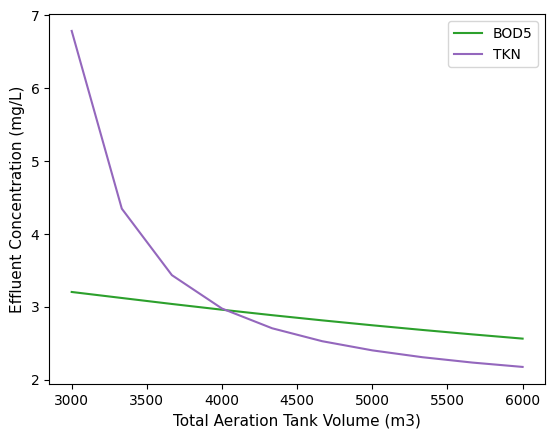

In [18]:
# Import package for sensitvity analysis
import numpy as np
import matplotlib.pyplot as plt
# Insert code for conducting sensitivity analysis
def sensitivity_analysis_case1(num):
    areation_tank_volume_list = np.linspace(1000, 2000, num)
    TSS_out_list = np.zeros(num)
    COD_out_list = np.zeros(num)
    BOD_out_list = np.zeros(num)
    TKN_out_list = np.zeros(num)
    for i in range(0, num):
        m = build()
        m.fs.R3.volume.unfix()
        m.fs.R3.volume.fix(areation_tank_volume_list[i])
        m.fs.R4.volume.unfix()
        m.fs.R4.volume.fix(areation_tank_volume_list[i])
        m.fs.R5.volume.unfix()
        m.fs.R5.volume.fix(areation_tank_volume_list[i])
        scale_system(m)
        initialize_system(m)
        add_costing(m)
        add_extra(m)
        results = solver.solve(m, tee=False)
        pyo.assert_optimal_termination(results)
        TSS_out_list[i]=pyo.value(m.fs.Treated.properties[0].TSS * 1e3)
        COD_out_list[i]=pyo.value(m.fs.Treated.properties[0].COD * 1e3)
        BOD_out_list[i]=pyo.value(m.fs.Treated.properties[0].BOD5["effluent"] * 1e3)
        TKN_out_list[i]=pyo.value(m.fs.Treated.properties[0].TKN * 1e3)

    fig1, ax1 = plt.subplots()
    # ax1.plot(3*areation_tank_volume_list, TSS_out_list, color="tab:blue", label="TSS")
    # ax1.plot(3*areation_tank_volume_list, COD_out_list, color="tab:red", label="COD")
    ax1.plot(3*areation_tank_volume_list, BOD_out_list, color="tab:green", label="BOD5")
    ax1.plot(3*areation_tank_volume_list, TKN_out_list, color="tab:purple", label="TKN")
    ax1.set_xlabel("Total Aeration Tank Volume (m3)", fontsize=11)
    ax1.set_ylabel("Effluent Concentration (mg/L)", fontsize=11)
    ax1.legend()
    
    # plt.show()
   
sensitivity_analysis_case1(num=10)

We also show the impacts of recycle fraction on effluent metrics. As recycle fraction increases, the effluent concentration will also increase.

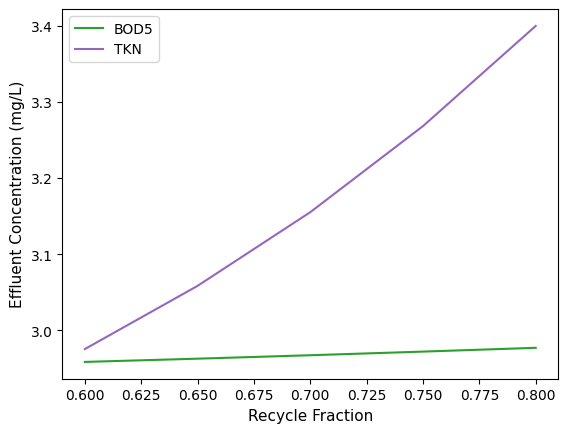

In [19]:
def sensitivity_analysis_case2(num):
    split_fraction_list = np.linspace(0.6, 0.8, num)
    TSS_out_list = np.zeros(num)
    COD_out_list = np.zeros(num)
    BOD_out_list = np.zeros(num)
    TKN_out_list = np.zeros(num)
    LCOW_list = np.zeros(num)
    SEC_list = np.zeros(num)
    for i in range(0, num):
        m = build()
        m.fs.SP5.split_fraction[:, "underflow"].unfix()
        m.fs.SP5.split_fraction[:, "underflow"].fix(split_fraction_list[i])
        scale_system(m)
        initialize_system(m)
        add_costing(m)
        add_extra(m)
        results = solver.solve(m, tee=False)
        pyo.assert_optimal_termination(results)
        TSS_out_list[i]=pyo.value(m.fs.Treated.properties[0].TSS * 1e3)
        COD_out_list[i]=pyo.value(m.fs.Treated.properties[0].COD * 1e3)
        BOD_out_list[i]=pyo.value(m.fs.Treated.properties[0].BOD5["effluent"] * 1e3)
        TKN_out_list[i]=pyo.value(m.fs.Treated.properties[0].TKN * 1e3)
        LCOW_list[i]=pyo.value(m.fs.costing.LCOW)
        SEC_list[i]=pyo.value(m.fs.costing.specific_energy_consumption)

    fig1, ax1 = plt.subplots()
    # ax1.plot(R3_volume_list, TSS_out_list, color="tab:blue", label="TSS")
    # ax1.plot(R3_volume_list, COD_out_list, color="tab:red", label="COD")
    ax1.plot(split_fraction_list, BOD_out_list, color="tab:green", label="BOD5")
    ax1.plot(split_fraction_list, TKN_out_list, color="tab:purple", label="TKN")
    ax1.set_xlabel("Recycle Fraction", fontsize=11)
    ax1.set_ylabel("Effluent Concentration (mg/L)", fontsize=11)
    ax1.legend()

sensitivity_analysis_case2(num=5)

We made contour plot to visualize the impacts of combination of variables on effluent metrics and LCOW. Higher anoxic and aeration tank volume will result in a lower COD concentration in the secondary effluent. And higher volumes also result in a higher LCOW.

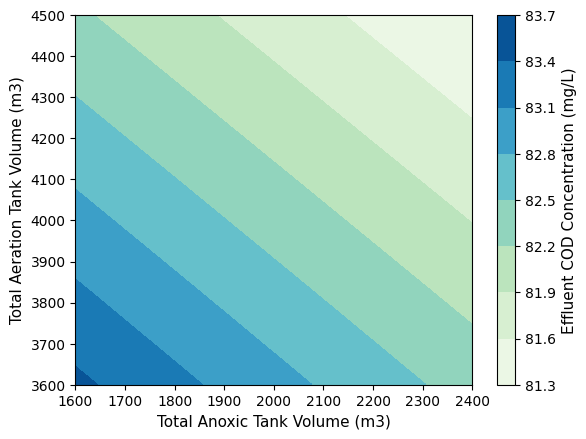

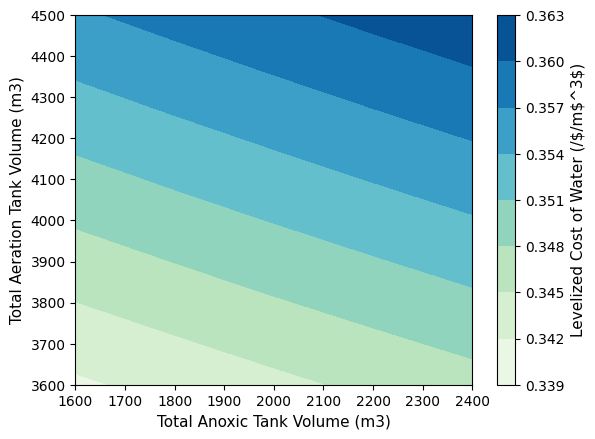

In [20]:
def sensitivity_analysis_case3(num):
    anoxic_tank_volume_list = np.linspace(800, 1200, num)
    areation_tank_volume_list = np.linspace(1200, 1500, num)
    TSS_out_matrix = np.zeros((num, num))
    COD_out_matrix = np.zeros((num, num))
    BOD_out_matrix = np.zeros((num, num))
    TKN_out_matrix = np.zeros((num, num))
    LCOW_matrix = np.zeros((num, num))
    SEC_matrix = np.zeros((num, num))
    for i in range(0, num):
        for j in range(0, num):
            m = build()
            m.fs.R1.volume.unfix()
            m.fs.R1.volume.fix(anoxic_tank_volume_list[i])
            m.fs.R2.volume.unfix()
            m.fs.R2.volume.fix(anoxic_tank_volume_list[i])
            m.fs.R3.volume.unfix()
            m.fs.R3.volume.fix(areation_tank_volume_list[j])
            m.fs.R4.volume.unfix()
            m.fs.R4.volume.fix(areation_tank_volume_list[j])
            m.fs.R5.volume.unfix()
            m.fs.R5.volume.fix(areation_tank_volume_list[j])
            scale_system(m)
            initialize_system(m)
            add_costing(m)
            add_extra(m)
            results = solver.solve(m, tee=False)
            pyo.assert_optimal_termination(results)
            TSS_out_matrix[j, i]=pyo.value(m.fs.Treated.properties[0].TSS * 1e3)
            COD_out_matrix[j, i]=pyo.value(m.fs.Treated.properties[0].COD * 1e3)
            BOD_out_matrix[j, i]=pyo.value(m.fs.Treated.properties[0].BOD5["effluent"] * 1e3)
            TKN_out_matrix[j, i]=pyo.value(m.fs.Treated.properties[0].TKN * 1e3)
            LCOW_matrix[j, i]=pyo.value(m.fs.costing.LCOW)
            SEC_matrix[j,i]=pyo.value(m.fs.costing.specific_energy_consumption)

    fig1, ax1 = plt.subplots()
    CF = ax1.contourf(2*anoxic_tank_volume_list, 3*areation_tank_volume_list, COD_out_matrix, cmap="GnBu")
    ax1.set_xlabel("Total Anoxic Tank Volume (m3)", fontsize=11)
    ax1.set_ylabel("Total Aeration Tank Volume (m3)", fontsize=11)
    cbar = fig1.colorbar(CF)
    cbar.ax.set_ylabel("Effluent COD Concentration (mg/L)", fontsize=11)

    fig2, ax2 = plt.subplots()
    CF = ax2.contourf(2*anoxic_tank_volume_list, 3*areation_tank_volume_list, LCOW_matrix, cmap="GnBu")
    ax2.set_xlabel("Total Anoxic Tank Volume (m3)", fontsize=11)
    ax2.set_ylabel("Total Aeration Tank Volume (m3)", fontsize=11)
    cbar = fig2.colorbar(CF)
    cbar.ax.set_ylabel("Levelized Cost of Water (/$/m$^3$)", fontsize=11)
   
sensitivity_analysis_case3(num=5)